# Multivariate Time-Series Regression Problem (use multiple records with multiple variables in past to predict 4 variables in a single record in future)

In [62]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Conv1D, MaxPool1D, add, AveragePooling1D, Dense, Dropout, BatchNormalization, Flatten, Input
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
#from datetime import datetime
from google.colab import drive
from os import listdir
import os
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from keras import models, optimizers as opts
tf.keras.optimizers.Optimizer
tf.keras.callbacks.LearningRateScheduler
from numpy import mean
from keras.regularizers import l2


In [63]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [64]:
base_path =  "/content/gdrive/MyDrive/Deep Learning/DL_project"
# Change the working directory to the base_path
os.chdir(base_path)

In [65]:
df = pd.read_csv('measures_v2.csv')
df.shape

(1330816, 13)

In [66]:
df.head()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
0,-0.450682,18.805172,19.086670,-0.350055,18.293219,0.002866,0.004419,0.000328,24.554214,18.316547,19.850691,0.187101,17
1,-0.325737,18.818571,19.092390,-0.305803,18.294807,0.000257,0.000606,-0.000785,24.538078,18.314955,19.850672,0.245417,17
2,-0.440864,18.828770,19.089380,-0.372503,18.294094,0.002355,0.001290,0.000386,24.544693,18.326307,19.850657,0.176615,17
3,-0.327026,18.835567,19.083031,-0.316199,18.292542,0.006105,0.000026,0.002046,24.554018,18.330833,19.850647,0.238303,17
4,-0.471150,18.857033,19.082525,-0.332272,18.291428,0.003133,-0.064317,0.037184,24.565397,18.326662,19.850639,0.208197,17


In [67]:
# change the order of cols
new_cols = ['u_q','coolant','u_d','motor_speed','i_d','i_q','ambient', 'torque','pm','stator_yoke','stator_tooth','stator_winding','profile_id']
df=df.reindex(columns=new_cols)
df.head()

,u_q,coolant,u_d,motor_speed,i_d,i_q,ambient,torque,pm,stator_yoke,stator_tooth,stator_winding,profile_id
0,-0.450682,18.805172,-0.350055,0.002866,0.004419,0.000328,19.850691,0.187101,24.554214,18.316547,18.293219,19.086670,17
1,-0.325737,18.818571,-0.305803,0.000257,0.000606,-0.000785,19.850672,0.245417,24.538078,18.314955,18.294807,19.092390,17
2,-0.440864,18.828770,-0.372503,0.002355,0.001290,0.000386,19.850657,0.176615,24.544693,18.326307,18.294094,19.089380,17
3,-0.327026,18.835567,-0.316199,0.006105,0.000026,0.002046,19.850647,0.238303,24.554018,18.330833,18.292542,19.083031,17
4,-0.471150,18.857033,-0.332272,0.003133,-0.064317,0.037184,19.850639,0.208197,24.565397,18.326662,18.291428,19.082525,17


In [68]:
# split the dataset
# Making the profile id 65 and 72 as the two testing sets and rest as the training set
df_test1set = df[(df['profile_id'] == 72)]
df_test2set = df[(df['profile_id'] == 65)]

# Only 20, 18 and 66 profiles will be included in the training set to reduce the dataset size. Higher computations needed.
df_trainset = df[(df['profile_id'] != 65) & (df['profile_id'] != 72) & (df['profile_id'] != 20) & (df['profile_id'] != 6) & (df['profile_id'] != 18) & (df['profile_id'] != 13) & (df['profile_id'] != 27) & (df['profile_id'] != 53)]
#df_trainset = df[(df['profile_id'] == 20) & (df['profile_id'] == 18) & (df['profile_id'] == 66)]

In [69]:
df_trainset.drop(['profile_id','torque'],axis = 1,inplace=True)
df_test1set.drop(['profile_id','torque'],axis = 1,inplace=True)
df_test2set.drop(['profile_id','torque'],axis = 1,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


# Preparing the training data set

In [70]:
df_trainset.head()
df_trainset.shape

(1049621, 11)

In [71]:
cols = list(df_trainset)[0:12]
print(cols)

['u_q', 'coolant', 'u_d', 'motor_speed', 'i_d', 'i_q', 'ambient', 'pm', 'stator_yoke', 'stator_tooth', 'stator_winding']


In [72]:
#New dataframe with only training data - 12 columns
df_for_training = df_trainset[cols].astype(float)

In [73]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [74]:
df_for_training_scaled.shape

(1049621, 11)

In [75]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 12. We will make timesteps = 10 (past records data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of records we want to look into the future based on the past records.
n_past = 10  # Number of past records we want to use to predict the future.

In [76]:
#Reformat input data into a shape: (n_samples x timesteps x n_features)
#Here df_for_training_scaled has a shape (983116, 12)
#983116 refers to the number of data points and 12 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 7:12])   #here, 7:12 represnt the index of varibales we need to predict. Can update this to predict single varible 

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (1049611, 10, 11).
trainY shape == (1049611, 1, 4).


#In here, trainX has a shape (983106, 10, 12). 
#983106 because we are looking back 10 records (983106 - 10 = 983096). 
#Remember that we cannot look back 10 records until we get to the 11th record. 
#Also, trainY has a shape (983906, 1). Our model predicts 4 value, but 
#it needs multiple variables (12) to make this prediction. 
#This is why we can only predict a single record after our training, the records after where our data ends.
#To predict more records in future, we need all the 12 variables which we do not have. 
#We need to predict all variables if we want to do that. 


In [77]:
print(trainX[0])
print(trainY[0])

[[-1.29081619 -0.85014915  0.3937053  -1.24144134  1.04634105 -0.37664358
  -2.35210038 -1.87611428 -1.54740822 -1.74390837 -1.69049541]
 [-1.28800392 -0.84955083  0.39440726 -1.24144279  1.04628244 -0.37665564
  -2.35211005 -1.87699026 -1.54748711 -1.74383888 -1.6902955 ]
 [-1.29059522 -0.84909543  0.39334921 -1.24144163  1.04629294 -0.37664294
  -2.35211778 -1.87663117 -1.54692471 -1.74387008 -1.69040069]
 [-1.28803293 -0.84879188  0.39424235 -1.24143955  1.04627352 -0.37662497
  -2.35212261 -1.87612495 -1.54670049 -1.74393799 -1.6906226 ]
 [-1.2912769  -0.84783338  0.39398738 -1.2414412   1.04528455 -0.37624432
  -2.35212648 -1.87550721 -1.54690714 -1.74398671 -1.69064026]
 [-1.29280346 -0.84584559  0.39940331 -1.2414376   1.03684136 -0.37299913
  -2.35212938 -1.87506186 -1.54704585 -1.74402166 -1.69082957]
 [-1.29537334 -0.84405217  0.4030477  -1.24144219  1.03081601 -0.37064333
  -2.35213131 -1.87490023 -1.54714128 -1.74393874 -1.69091783]
 [-1.29774217 -0.84319706  0.40552565 -1.

# Preparing the testing data set

In [78]:
print(df_test1set.head())
print(df_test1set.shape)
print(df_test2set.head())
print(df_test2set.shape)

              u_q    coolant        u_d  motor_speed        i_d         i_q  \
984807  -1.887356  30.721162   1.946434     0.022686  -2.001102    1.098022   
984808   0.604919  30.721209   0.109622    27.444022  -8.944310   26.184500   
984809   4.665253  30.721242  -6.753488   116.920677 -35.659968   80.725465   
984810   9.206368  30.721266 -16.699363   251.384409 -59.658771  125.454513   
984811  14.197583  30.720804 -28.559625   418.588814 -77.320911  158.080952   

          ambient         pm  stator_yoke  stator_tooth  stator_winding  
984807  23.886441  37.112483    30.660012     31.291477       32.113178  
984808  23.885538  37.111457    30.708855     31.296847       32.115623  
984809  23.883657  37.116662    30.743853     31.283346       32.122736  
984810  23.880380  36.924837    30.777050     31.283340       32.130268  
984811  23.874869  36.922961    30.820728     31.212032       32.117775  
(15301, 11)
              u_q    coolant       u_d  motor_speed        i_d       

In [79]:
cols = list(df_test1set)[0:12]
print(cols)

['u_q', 'coolant', 'u_d', 'motor_speed', 'i_d', 'i_q', 'ambient', 'pm', 'stator_yoke', 'stator_tooth', 'stator_winding']


In [80]:
#New dataframe with only training data - 11 columns
df_for_testing1 = df_test1set[cols].astype(float)
df_for_testing2 = df_test2set[cols].astype(float)

In [81]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the testing 1 dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_testing1)
df_for_testing1_scaled = scaler.transform(df_for_testing1)

# normalize the testing 2 dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_testing2)
df_for_testing2_scaled = scaler.transform(df_for_testing2)

In [82]:
print(df_for_testing1_scaled.shape)
print(df_for_testing2_scaled.shape)

(15301, 11)
(40094, 11)


In [83]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 12. We will make timesteps = 10 (past records data used for training). 

#Empty lists to be populated using formatted training data
test1X = []
test1Y = []
test2X = []
test2Y = []


In [84]:
n_future = 1   # Number of records we want to look into the future based on the past records.
n_past = 10  # Number of past days we want to use to predict the future.
n_feature_predict = 4

In [85]:
#Reformat input data into a shape: (n_samples x timesteps x n_features)
#Here df_for_training_scaled has a shape (983116, 12)
#983116 refers to the number of data points and 12 refers to the columns (multi-variables).

#for testing set1
for i in range(n_past, len(df_for_testing1_scaled) - n_future +1):
    test1X.append(df_for_testing1_scaled[i - n_past:i, 0:df_for_testing1.shape[1]])
    test1Y.append(df_for_testing1_scaled[i + n_future - 1:i + n_future, 7:12])   #here, 8:12 represnt the index of varibales we need to predict. Can update this to predict single varible 

test1X, test1Y = np.array(test1X), np.array(test1Y)

print('test1X shape == {}.'.format(test1X.shape))
print('test1Y shape == {}.'.format(test1Y.shape))




#for testing set2
for i in range(n_past, len(df_for_testing2_scaled) - n_future +1):
    test2X.append(df_for_testing2_scaled[i - n_past:i, 0:df_for_testing2.shape[1]])
    test2Y.append(df_for_testing2_scaled[i + n_future - 1:i + n_future, 7:12])   #here, 8:12 represnt the index of varibales we need to predict. Can update this to predict single varible 

test2X, test2Y = np.array(test2X), np.array(test2Y)

print('test2X shape == {}.'.format(test2X.shape))
print('test2Y shape == {}.'.format(test2Y.shape))

test1X shape == (15291, 10, 11).
test1Y shape == (15291, 1, 4).
test2X shape == (40084, 10, 11).
test2Y shape == (40084, 1, 4).


In [86]:
print(test1X[0])
print(test1Y[0])
print(test2X[0])
print(test2Y[0])

[[-8.78772845e-01 -7.56371740e-01  3.45559522e-02 -8.12250541e-01
   7.50442825e-01 -4.51270049e-02 -1.80336035e+00 -2.24822679e+00
  -1.15274113e+00 -1.35652784e+00 -1.47226284e+00]
 [-8.25551818e-01 -7.56369847e-01 -9.13754760e-05 -7.97354756e-01
   6.23326560e-01  2.73478543e-01 -1.80566932e+00 -2.24833480e+00
  -1.15037549e+00 -1.35626666e+00 -1.47215309e+00]
 [-7.38845823e-01 -7.56368490e-01 -1.29548453e-01 -7.48749358e-01
   1.34216246e-01  9.66164622e-01 -1.81047760e+00 -2.24778655e+00
  -1.14868043e+00 -1.35692325e+00 -1.47183376e+00]
 [-6.41873056e-01 -7.56367518e-01 -3.17154917e-01 -6.75706134e-01
  -3.05153865e-01  1.53423651e+00 -1.81885482e+00 -2.26799373e+00
  -1.14707256e+00 -1.35692357e+00 -1.47149565e+00]
 [-5.35288682e-01 -7.56386252e-01 -5.40871998e-01 -5.84877562e-01
  -6.28512354e-01  1.94860176e+00 -1.83294313e+00 -2.26819135e+00
  -1.14495711e+00 -1.36039158e+00 -1.47205650e+00]
 [-4.22180826e-01 -7.56391199e-01 -7.91230291e-01 -4.81303549e-01
  -8.65055007e-01  

# Model Development

In [87]:
# Setting some hyper-parameters for models
epochs = 20
batch_size=1000
# batch_size=500

# Training inputs and outputs
seq_len = trainX.shape[1]  #this is total number of records
n_input_features = trainX.shape[2]  #this is 12
n_targets = trainY.shape[1]*trainY.shape[2]   #this is 1*4

# LSTM model

In [27]:
# define the Autoencoder model
def LSTM_model_builder(seq_len, n_input_features, n_targets):
  model = Sequential()

  model.add(LSTM(1024, activation='relu', input_shape=(seq_len, n_input_features), return_sequences=True))
  model.add(LSTM(512, activation='relu', return_sequences=True))
  model.add(Dropout(0.3))
  model.add(LSTM(128, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01), activation='relu', return_sequences=True))
  model.add(LSTM(64, activation='relu', return_sequences=True))
  model.add(BatchNormalization())
  # model.add(AveragePooling1D(pool_size=2, strides=1, padding='same'))
  model.add(LSTM(32, activation='relu', return_sequences=False))
  model.add(Dropout(0.1))
  model.add(Dense(n_targets, activation='linear'))

  return model

In [28]:
model = LSTM_model_builder(seq_len, n_input_features, n_targets)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 1024)          4243456   
                                                                 
 lstm_1 (LSTM)               (None, 10, 512)           3147776   
                                                                 
 dropout (Dropout)           (None, 10, 512)           0         
                                                                 
 lstm_2 (LSTM)               (None, 10, 128)           328192    
                                                                 
 lstm_3 (LSTM)               (None, 10, 64)            49408     
                                                                 
 batch_normalization (BatchN  (None, 10, 64)           256       
 ormalization)                                                   
                                                        

In [29]:
# Learning Rate Decay
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=5000,
    decay_rate=0.7)

opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=opt, loss='mse', metrics=['mse','mae'])

In [30]:
# A function for decaying the earning rate
# initial_learning_rate = 0.001
# decay = initial_learning_rate/epochs

# def lr_time_based_decay(epoch, lr):
#     return lr * 1 / (1 + decay * epoch)


model_es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_mse',
    min_delta = 0.001,
    patience = 20,
    verbose = 1,
    mode='min',
    restore_best_weights=True)


In [31]:
trainX.shape

(1049611, 10, 11)

In [32]:
# fit the model
# %%time
# history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1, callbacks=[model_es_callback, LearningRateScheduler(lr_time_based_decay, verbose=1)])

history = model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1, callbacks=[model_es_callback])

Epoch 1/20
840/840 [==============================] - 349s 404ms/step - loss: 1.7995 - mse: 1.0513 - mae: 0.8732 - val_loss: 1.0050 - val_mse: 0.8462 - val_mae: 0.7206
Epoch 2/20
840/840 [==============================] - 331s 394ms/step - loss: 1.1035 - mse: 1.0511 - mae: 0.8731 - val_loss: 0.8396 - val_mse: 0.8338 - val_mae: 0.7156
Epoch 3/20
840/840 [==============================] - 330s 393ms/step - loss: 1.0525 - mse: 1.0511 - mae: 0.8731 - val_loss: 0.8430 - val_mse: 0.8432 - val_mae: 0.7191
Epoch 4/20
840/840 [==============================] - 329s 392ms/step - loss: 1.0511 - mse: 1.0511 - mae: 0.8730 - val_loss: 0.8473 - val_mse: 0.8475 - val_mae: 0.7210
Epoch 5/20
840/840 [==============================] - 329s 392ms/step - loss: 1.0511 - mse: 1.0511 - mae: 0.8730 - val_loss: 0.8448 - val_mse: 0.8450 - val_mae: 0.7198
Epoch 6/20
840/840 [==============================] - 328s 391ms/step - loss: 1.0511 - mse: 1.0511 - mae: 0.8730 - val_loss: 0.8387 - val_mse: 0.8390 - val_mae:

Ploting Performance of training

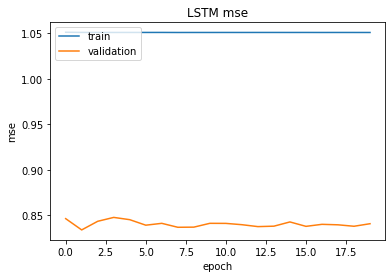

In [33]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('LSTM mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

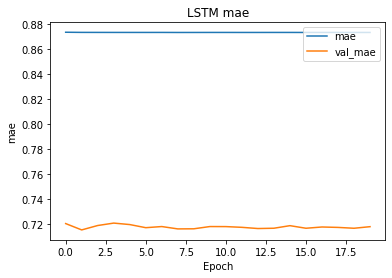

In [34]:
# cnn_model.evaluate(X_test, y_test, verbose = 0) 

plt.plot(history.history['mae'], label='mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.title('LSTM mae')
plt.xlabel('Epoch')
plt.ylabel('mae')
plt.legend(loc='upper right')
plt.show()

In [35]:
test1X.shape

(15291, 10, 11)

In [36]:
# print(history.history.keys())
print(model.metrics_names)

# Evaluate the model average testing performance 
result1 = model.evaluate(test1X,  test1Y, verbose=2)
result2 = model.evaluate(test2X,  test2Y, verbose=2)

print('MSE testing set1: %.3f' % (result1[1]))
print('MAE testing set1: %.3f' % (result1[2]))
print('MSE testing set2 : %.3f' % (result2[1]))
print('MAE testing set2: %.3f' % (result2[2]))

['loss', 'mse', 'mae']
478/478 - 11s - loss: 1.0081 - mse: 1.0080 - mae: 0.8717 - 11s/epoch - 23ms/step
1253/1253 - 34s - loss: 1.0083 - mse: 1.0081 - mae: 0.8637 - 34s/epoch - 27ms/step
MSE testing set1: 1.008
MAE testing set1: 0.872
MSE testing set2 : 1.008
MAE testing set2: 0.864


Predictictions

In [37]:
# Here we do not need to perform inverse scaling as we do not want to see the predicted values in their real scale
# Refer to the original teaching material at https://www.youtube.com/watch?v=tepxdcepTbY

In [38]:
# Predict the output 
test1Y_pred = []
test2Y_pred = []

# This can be run only once. Cecause it reshapes the original array
test1Y_shaped = test1Y.reshape((test1Y.shape[0],test1Y.shape[1]*test1Y.shape[2]))
test2Y_shaped = test2Y.reshape((test2Y.shape[0],test2Y.shape[1]*test2Y.shape[2]))

test1Y_pred= model.predict(test1X)
test2Y_pred= model.predict(test2X)


Predicting R2 for testing sets

In [39]:
r2_lstm1 = []
r2_lstm2 = []

# Predict R2 for test1 dataset
r2_lstm1 = r2_score(test1Y_shaped, test1Y_pred, multioutput='raw_values')
print('test1 R2:', r2_lstm1)
print('test1 average R2:', np.mean(r2_lstm1))

# Predict R2 for test2 dataset
r2_lstm2 = r2_score(test2Y_shaped, test2Y_pred, multioutput='raw_values')
print('test2 R2:', r2_lstm2)
print('test2 average R2:', np.mean(r2_lstm2))

test1 R2: [-0.00572907 -0.0170758  -0.00953445 -0.00411082]
test1 average R2: -0.009112531915719979
test2 R2: [-0.0055967  -0.01700595 -0.0094489  -0.0040413 ]
test2 average R2: -0.009023212908630784


Predicting MSE in testing sets

In [40]:
mse_lstm1 = []
mse_lstm2 = []

# Predict R2 for test1 dataset

mse_lstm1 = mean_squared_error(test1Y_shaped, test1Y_pred, multioutput='raw_values')
print('test1 MSE:', mse_lstm1)
print('test1 average MSE:', np.mean(mse_lstm1))

# Predict R2 for test2 dataset
mse_lstm2 = mean_squared_error(test2Y_shaped, test2Y_pred, multioutput='raw_values')
print('test2 MSE:', mse_lstm2)
print('test2 average MSE:', np.mean(mse_lstm2))

test1 MSE: [1.00306062 1.01686157 1.00897137 1.00334158]
test1 average MSE: 1.0080587879517064
test2 MSE: [1.00420032 1.01640018 1.00887887 1.00355421]
test2 average MSE: 1.0082583961958544


Predicting MAE in testing sets

In [41]:
mae_lstm1 = []
mae_lstm2 = []

# Predict mae for test1 dataset
mae_lstm1 = mean_absolute_error(test1Y_shaped, test1Y_pred, multioutput='raw_values')
print('test1 MAE:', mae_lstm1)
print('test1 average MAE:', np.mean(mae_lstm1))

# Predict mae for test2 dataset
mae_lstm2 = mean_absolute_error(test2Y_shaped, test2Y_pred, multioutput='raw_values')
print('test2 MAE:', mae_lstm2)
print('test2 average MAE:', np.mean(mae_lstm2))

test1 MAE: [0.85074434 0.87627268 0.87638247 0.88359734]
test1 average MAE: 0.8717492046646538
test2 MAE: [0.84422247 0.85847633 0.87123866 0.88113588]
test2 average MAE: 0.8637683326541309


# CNN model

In [88]:
def cnn_model_builder(seq_len, n_input_features, n_targets, kernel_size):
    # input shape: window_size x len(x_cols)
    x = Input((seq_len, n_input_features), name='input_62')
    y = Conv1D(filters=1024, kernel_size=kernel_size, padding='same', activation='relu')(x)

    y = Conv1D(filters=512, kernel_size=kernel_size, padding='same',
                      dilation_rate=2, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(y)
    y = Conv1D(filters=256, kernel_size=kernel_size, padding='same',
                      dilation_rate=2, activation='relu')(y)
    y = Conv1D(filters=128, kernel_size=2, padding='same',
                      dilation_rate=2, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(y)
    
#     y = AveragePooling1D(pool_size=2, strides=1, padding='same')(y)

    y = Conv1D(filters=256, kernel_size=kernel_size, padding='same',
                      dilation_rate=2, activation='relu')(y)
    
    shortcut = Conv1D(filters=256, kernel_size=1,
                             dilation_rate=2, padding='same')(x)
    y = add([shortcut, y])

    # y = MaxPool1D(pool_size=32)(y)
    y = Flatten()(y)
    y = Dense(128, name='dense_128', activation='relu')(y)
    y = Dropout(rate=0.05)(y)
    y = Dense(n_targets, name=f'dense_{n_targets}', activation='linear')(y)
    model = models.Model(inputs=x, outputs=y)

    return model
  
 

In [43]:
cnn_model = cnn_model_builder(seq_len, n_input_features, n_targets, kernel_size=3)
cnn_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_62 (InputLayer)          [(None, 10, 11)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 10, 1024)     34816       ['input_62[0][0]']               
                                                                                                  
 conv1d_1 (Conv1D)              (None, 10, 512)      1573376     ['conv1d[0][0]']                 
                                                                                                  
 conv1d_2 (Conv1D)              (None, 10, 256)      393472      ['conv1d_1[0][0]']               
                                                                                              

In [44]:
# Learning Rate Decay
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.7)

opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [45]:
cnn_model.compile(optimizer=opt, loss='mse', metrics=['mse','mae'])

In [46]:
# fit the model
# %%time
history = cnn_model.fit(trainX, trainY, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1, callbacks=[model_es_callback])

Epoch 1/20
840/840 [==============================] - 148s 163ms/step - loss: 1.1972 - mse: 1.0543 - mae: 0.8742 - val_loss: 0.8520 - val_mse: 0.8522 - val_mae: 0.7227
Epoch 2/20
840/840 [==============================] - 133s 158ms/step - loss: 1.0511 - mse: 1.0511 - mae: 0.8731 - val_loss: 0.8399 - val_mse: 0.8402 - val_mae: 0.7180
Epoch 3/20
840/840 [==============================] - 132s 158ms/step - loss: 1.0511 - mse: 1.0511 - mae: 0.8730 - val_loss: 0.8356 - val_mse: 0.8358 - val_mae: 0.7162
Epoch 4/20
840/840 [==============================] - 130s 155ms/step - loss: 1.0511 - mse: 1.0511 - mae: 0.8731 - val_loss: 0.8424 - val_mse: 0.8426 - val_mae: 0.7189
Epoch 5/20
840/840 [==============================] - 129s 153ms/step - loss: 1.0511 - mse: 1.0511 - mae: 0.8730 - val_loss: 0.8375 - val_mse: 0.8378 - val_mae: 0.7171
Epoch 6/20
840/840 [==============================] - 128s 153ms/step - loss: 1.0511 - mse: 1.0511 - mae: 0.8730 - val_loss: 0.8365 - val_mse: 0.8368 - val_mae:

Ploting Performance of training

In [89]:
cnn_model.save("cnn.h5")

In [1]:
# plt.plot(history.history['mse'], label='mse')
# plt.plot(history.history['val_mse'],label='val_mse')
# plt.title('CNN mse') 
# plt.ylabel('mse')
# plt.xlabel('epoch')
# plt.legend(['train', 'validation'], loc='upper left')
# plt.show()

In [2]:

# plt.plot(history.history['mae'], label='mae')
# plt.plot(history.history['val_mae'], label='val_mae')
# plt.title('CNN mae')
# plt.xlabel('Epoch')
# plt.ylabel('Mean_absolute_error')
# plt.legend(loc='upper right')
# plt.show()

In [49]:
test1X.shape

(15291, 10, 11)

In [50]:
# print(history.history.keys())
print(cnn_model.metrics_names)

# Evaluate the model average testing performance 
result1 = cnn_model.evaluate(test1X,  test1Y, verbose=2)
result2 = cnn_model.evaluate(test2X,  test2Y, verbose=2)

print('MSE testing set1: %.3f' % (result1[1]))
print('MAE testing set1: %.3f' % (result1[2]))
print('MSE testing set2 : %.3f' % (result2[1]))
print('MAE testing set2: %.3f' % (result2[2]))

['loss', 'mse', 'mae']
478/478 - 8s - loss: 1.0081 - mse: 1.0080 - mae: 0.8717 - 8s/epoch - 16ms/step
1253/1253 - 20s - loss: 1.0083 - mse: 1.0081 - mae: 0.8637 - 20s/epoch - 16ms/step
MSE testing set1: 1.008
MAE testing set1: 0.872
MSE testing set2 : 1.008
MAE testing set2: 0.864


Predictictions

Here we do not need to perform inverse scaling as we do not want to see the predicted values in their real scale
Refer to the original teaching material at https://www.youtube.com/watch?v=tepxdcepTbY

In [ ]:
# test1Y.shape

In [91]:
# Predict the output 
test1Y_predcnn = []
test2Y_predcnn = []

# This can be run only once. Cecause it reshapes the original array
test1Y_shaped = test1Y.reshape((test1Y.shape[0],test1Y.shape[1]*test1Y.shape[2]))
test2Y_shaped = test2Y.reshape((test2Y.shape[0],test2Y.shape[1]*test2Y.shape[2]))

test1Y_predcnn= model.predict(test1X)
test2Y_predcnn= model.predict(test2X)

In [ ]:
# Predict the output 
#test1Y_predcnn = []
#test2Y_predcnn = []

# This can be run only once. Cecause it reshapes the original array
#test1Y_shaped = test1Y.reshape((test1Y.shape[0],test1Y.shape[1]*test1Y.shape[2]))
#test2Y_shaped = test2Y.reshape((test2Y.shape[0],test2Y.shape[1]*test2Y.shape[2]))

#test1Y_predcnn= model.predict(test1X)
#test2Y_predcnn= model.predict(test2X)


Predicting R2 for testing sets

In [92]:
r2_cnn1 = []
r2_cnn2 = []

# Predict R2 for test1 dataset
r2_cnn1 = r2_score(test1Y_shaped, test1Y_predcnn, multioutput='raw_values')
print('test1 R2:', r2_cnn1)

# Predict R2 for test2 dataset
r2_cnn2 = r2_score(test2Y_shaped, test2Y_predcnn, multioutput='raw_values')
print('test2 R2:', r2_cnn2)

test1 R2: [-0.00572907 -0.0170758  -0.00953445 -0.00411082]
test2 R2: [-0.0055967  -0.01700595 -0.0094489  -0.0040413 ]


In [ ]:
r2_cnn1 = []
r2_cnn2 = []

# Predict R2 for test1 dataset
r2_cnn1 = r2_score(test1Y_shaped, test1Y_predcnn, multioutput='raw_values')
print('test1 R2:', r2_cnn1)

# Predict R2 for test2 dataset
r2_cnn2 = r2_score(test2Y_shaped, test2Y_predcnn, multioutput='raw_values')
print('test2 R2:', r2_cnn2)

In [ ]:
# test1X.shape

In [93]:
# print(history.history.keys())
print(model.metrics_names)

# Evaluate the model average testing performance 
result1 = model.evaluate(test1X,  test1Y, verbose=2)
result2 = model.evaluate(test2X,  test2Y, verbose=2)

print('MSE testing set1: %.3f' % (result1[1]))
print('MAE testing set1: %.3f' % (result1[2]))
print('MSE testing set2 : %.3f' % (result2[1]))
print('MAE testing set2: %.3f' % (result2[2]))

['loss', 'mse', 'mae']
478/478 - 8s - loss: 1.0081 - mse: 1.0080 - mae: 0.8717 - 8s/epoch - 16ms/step
1253/1253 - 24s - loss: 1.0083 - mse: 1.0081 - mae: 0.8637 - 24s/epoch - 19ms/step
MSE testing set1: 1.008
MAE testing set1: 0.872
MSE testing set2 : 1.008
MAE testing set2: 0.864


Predictictions

In [94]:
# Predict the output 
test1Y_pred = []
test2Y_pred = []

# This can be run only once. Cecause it reshapes the original array
test1Y_shaped = test1Y.reshape((test1Y.shape[0],test1Y.shape[1]*test1Y.shape[2]))
test2Y_shaped = test2Y.reshape((test2Y.shape[0],test2Y.shape[1]*test2Y.shape[2]))

test1Y_pred= model.predict(test1X)
test2Y_pred= model.predict(test2X)

In [ ]:
# # Predict the output 
# test1Y_pred = []
# test2Y_pred = []

# # This can be run only once. Cecause it reshapes the original array
# test1Y_shaped = test1Y.reshape((test1Y.shape[0],test1Y.shape[1]*test1Y.shape[2]))
# test2Y_shaped = test2Y.reshape((test2Y.shape[0],test2Y.shape[1]*test2Y.shape[2]))

# test1Y_pred= model.predict(test1X)
# test2Y_pred= model.predict(test2X)


Predicting R2 for testing sets

In [95]:
r2_lstm1 = []
r2_lstm2 = []

# Predict R2 for test1 dataset
r2_lstm1 = r2_score(test1Y_shaped, test1Y_pred, multioutput='raw_values')
print('test1 R2:', r2_lstm1)
print('test1 average R2:', np.mean(r2_lstm1))

# Predict R2 for test2 dataset
r2_lstm2 = r2_score(test2Y_shaped, test2Y_pred, multioutput='raw_values')
print('test2 R2:', r2_lstm2)
print('test2 average R2:', np.mean(r2_lstm2))

test1 R2: [-0.00572907 -0.0170758  -0.00953445 -0.00411082]
test1 average R2: -0.009112531915719979
test2 R2: [-0.0055967  -0.01700595 -0.0094489  -0.0040413 ]
test2 average R2: -0.009023212908630784


In [ ]:
# r2_lstm1 = []
# r2_lstm2 = []

# # Predict R2 for test1 dataset
# r2_lstm1 = r2_score(test1Y_shaped, test1Y_pred, multioutput='raw_values')
# print('test1 R2:', r2_lstm1)
# print('test1 average R2:', np.mean(r2_lstm1))

# # Predict R2 for test2 dataset
# r2_lstm2 = r2_score(test2Y_shaped, test2Y_pred, multioutput='raw_values')
# print('test2 R2:', r2_lstm2)
# print('test2 average R2:', np.mean(r2_lstm2))

Predicting MSE in testing sets

In [96]:
mse_cnn1 = []
mse_cnn2 = []

# Predict mse for test1 dataset
mse_cnn1 = mean_squared_error(test1Y_shaped, test1Y_predcnn, multioutput='raw_values')
print('test1 MSE:', mse_cnn1)
print('test1 average MSE:', np.mean(mse_cnn1))

# Predict mse for test2 dataset
mse_cnn2 = mean_squared_error(test2Y_shaped, test2Y_predcnn, multioutput='raw_values')
print('test2 MSE:', mse_cnn2)
print('test2 average MSE:', np.mean(mse_cnn2))

test1 MSE: [1.00306062 1.01686157 1.00897137 1.00334158]
test1 average MSE: 1.0080587879517064
test2 MSE: [1.00420032 1.01640018 1.00887887 1.00355421]
test2 average MSE: 1.0082583961958544


In [ ]:
# mse_cnn1 = []
# mse_cnn2 = []

# # Predict mse for test1 dataset
# mse_cnn1 = mean_squared_error(test1Y_shaped, test1Y_predcnn, multioutput='raw_values')
# print('test1 MSE:', mse_cnn1)
# print('test1 average MSE:', np.mean(mse_cnn1))

# # Predict mse for test2 dataset
# mse_cnn2 = mean_squared_error(test2Y_shaped, test2Y_predcnn, multioutput='raw_values')
# print('test2 MSE:', mse_cnn2)
# print('test2 average MSE:', np.mean(mse_cnn2))

Predicting MAE in testing sets

In [97]:
mae_cnn1 = []
mae_cnn2 = []

# Predict mae for test1 dataset

mae_cnn1 = mean_absolute_error(test1Y_shaped, test1Y_predcnn, multioutput='raw_values')
print('test1 MAE:', mae_cnn1)
print('test1 average MAE:', np.mean(mae_cnn1))

# Predict mae for test2 dataset
mae_cnn2 = mean_absolute_error(test2Y_shaped, test2Y_predcnn, multioutput='raw_values')
print('test2 MAE:', mae_cnn2)
print('test2 average MAE:', np.mean(mae_cnn2))

test1 MAE: [0.85074434 0.87627268 0.87638247 0.88359734]
test1 average MAE: 0.8717492046646538
test2 MAE: [0.84422247 0.85847633 0.87123866 0.88113588]
test2 average MAE: 0.8637683326541309
